# LSTM 

### Importing the module that scrapes the internet for the latest values count

In [2]:
import csv_updater

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

#### Getting the starter data from John Hopkin's CSV File

In [4]:
df = pd.read_csv("johnhopkins-3March.csv")

In [5]:
df = df.T

In [6]:
cols_drop = []
for i in range(114):
    if i != 0 and i != 5:
        cols_drop.append(i)
df.drop(df.columns[cols_drop], axis = 1, inplace = True) 

In [7]:
df.drop(['Country/Region', 'WHO region', 'Province/States'], inplace = True)

#### Cleaning the Data

In [8]:
df.head()

,0,5
1/21/2020,282,NaN
1/22/2020,314,NaN
1/23/2020,581,NaN
1/24/2020,846,NaN
1/25/2020,1320,NaN


In [9]:
df.shape

(46, 2)

In [10]:
df.rename(columns = {0:'Infected', 5:'Deaths'}, inplace = True)

In [11]:
df.head()

,Infected,Deaths
1/21/2020,282,NaN
1/22/2020,314,NaN
1/23/2020,581,NaN
1/24/2020,846,NaN
1/25/2020,1320,NaN


In [12]:
df.shape

(46, 2)

#### Using the dates as indices

In [15]:
dates_unix = []
start = 1579478400
for i in range(46):
    start += 86400
    dates_unix.append(start)

print(dates_unix)

[1579564800, 1579651200, 1579737600, 1579824000, 1579910400, 1579996800, 1580083200, 1580169600, 1580256000, 1580342400, 1580428800, 1580515200, 1580601600, 1580688000, 1580774400, 1580860800, 1580947200, 1581033600, 1581120000, 1581206400, 1581292800, 1581379200, 1581465600, 1581552000, 1581638400, 1581724800, 1581811200, 1581897600, 1581984000, 1582070400, 1582156800, 1582243200, 1582329600, 1582416000, 1582502400, 1582588800, 1582675200, 1582761600, 1582848000, 1582934400, 1583020800, 1583107200, 1583193600, 1583280000, 1583366400, 1583452800]


In [16]:
df['Date'] = dates_unix

In [17]:
df.head()

,Infected,Deaths,Date
1/21/2020,282,NaN,1579564800
1/22/2020,314,NaN,1579651200
1/23/2020,581,NaN,1579737600
1/24/2020,846,NaN,1579824000
1/25/2020,1320,NaN,1579910400


In [18]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')

In [19]:
df.head()

,Infected,Deaths,Date
1/21/2020,282,NaN,2020-01-21
1/22/2020,314,NaN,2020-01-22
1/23/2020,581,NaN,2020-01-23
1/24/2020,846,NaN,2020-01-24
1/25/2020,1320,NaN,2020-01-25


In [20]:
df.set_index = df['Date']

In [21]:
start

1583452800

In [22]:
df.head()

,Infected,Deaths,Date
1/21/2020,282,NaN,2020-01-21
1/22/2020,314,NaN,2020-01-22
1/23/2020,581,NaN,2020-01-23
1/24/2020,846,NaN,2020-01-24
1/25/2020,1320,NaN,2020-01-25


In [23]:
df = df.reset_index(drop=True)

In [24]:
df.set_index("Date", inplace = True) 

In [25]:
df.head()

,Infected,Deaths
Date,,
2020-01-21,282,NaN
2020-01-22,314,NaN
2020-01-23,581,NaN
2020-01-24,846,NaN
2020-01-25,1320,NaN


In [26]:
df.fillna(0, inplace=True)

In [27]:
df.head()

,Infected,Deaths
Date,,
2020-01-21,282.0,0.0
2020-01-22,314.0,0.0
2020-01-23,581.0,0.0
2020-01-24,846.0,0.0
2020-01-25,1320.0,0.0


### Plotting the data

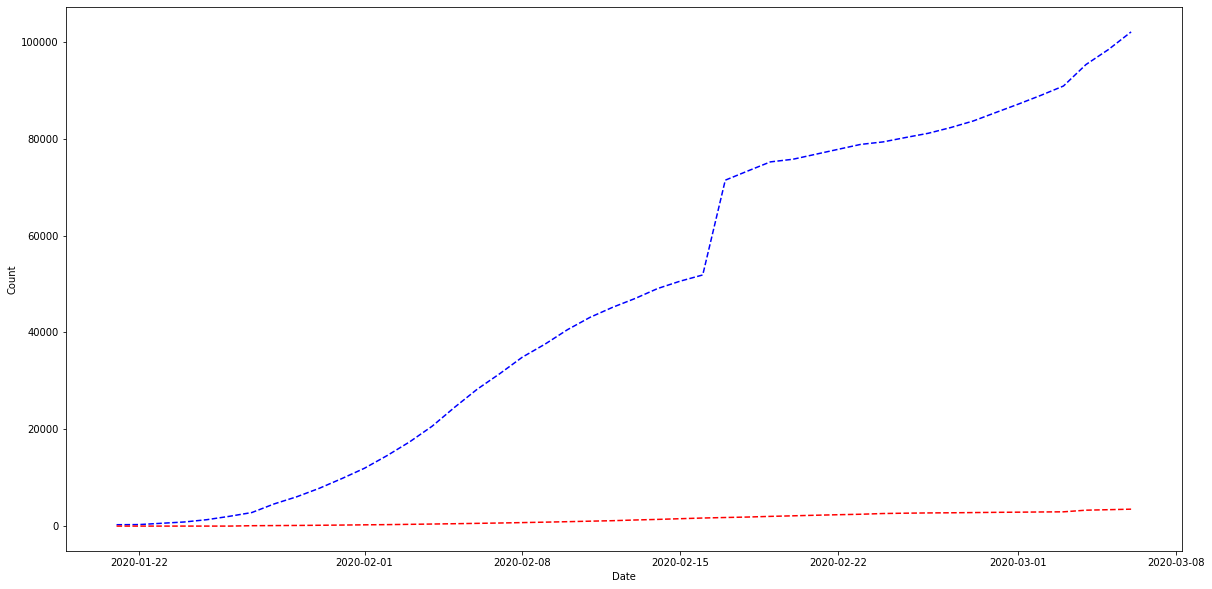

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(df.Infected, 'b--')
plt.plot(df.Deaths, 'r--')
plt.ylabel("Count")
plt.xlabel("Date")
plt.show()

In [29]:
infected, deaths = csv_updater.get_nums()

In [30]:
import datetime
now = datetime.datetime.now()

In [31]:
currdate = now.strftime("%Y-%m-%d")

In [32]:
infected, deaths

(10418, 3526)

In [33]:
currdate = '2020-03-06'
currdate = pd.to_datetime(currdate)

In [34]:
df.loc[currdate]= [infected, deaths]

In [35]:
df.tail(1)

,Infected,Deaths
Date,,
2020-03-06,10418.0,3526.0


In [36]:
if df.loc[currdate].any():
    print("Data already exists")    
else:
    df.loc[currdate] = [infected, deaths]

Data already exists


In [37]:
df.tail()

,Infected,Deaths
Date,,
2020-03-02,88948.0,2915.0
2020-03-03,90870.0,2946.0
2020-03-04,95310.0,3285.0
2020-03-05,98419.0,3387.0
2020-03-06,10418.0,3526.0


In [38]:
df.loc['2020-03-04'] = [95310,3285]

In [39]:
df.loc['2020-03-05'] = [98414,3387]

In [41]:
# df.drop(['2020-03-04','2020-03-05'], inplace=True)

### Exporting the well structured data

In [42]:
df.to_csv("StructuredDataset.csv")

In [43]:
df = pd.read_csv("StructuredDataset.csv")

In [44]:
df.set_index('Date', inplace = True)

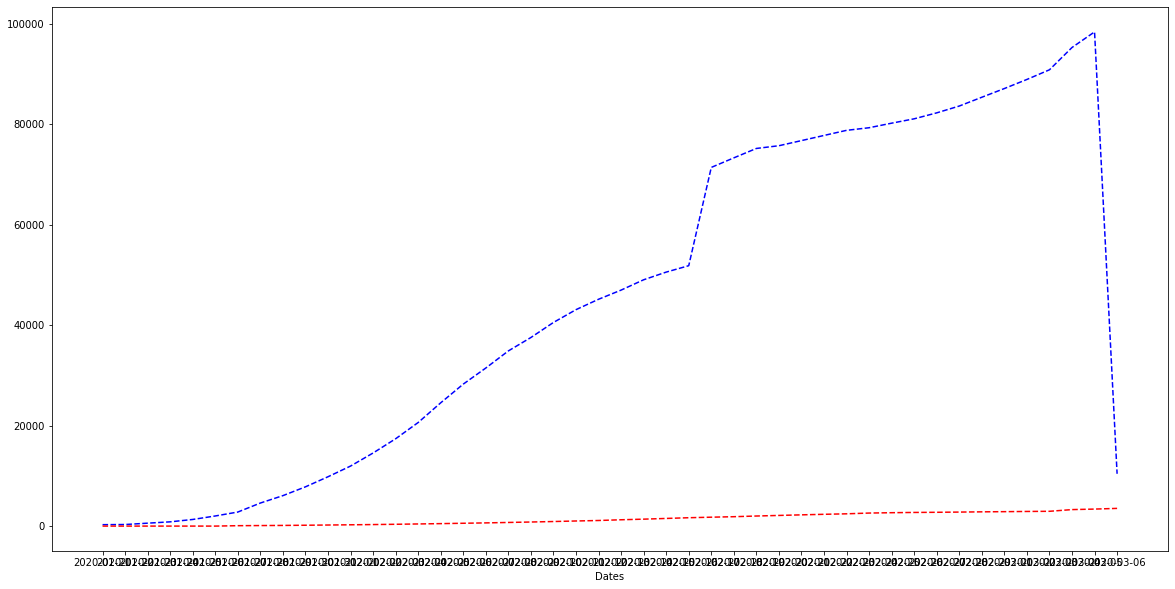

In [45]:
plt.figure(figsize=(20,10))
plt.plot(df.Infected, 'b--')
plt.plot(df.Deaths, 'r--')
plt.xlabel('Dates')
plt.show()

## LSTM

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [47]:
tr_inf, tr_dea = df.Infected, df.Deaths

### Forecasting Infected Numbers

In [48]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data_inf = sc.fit_transform(tr_inf.values.reshape(-1, 1))

seq_length = 4
x_inf, y_inf = sliding_windows(training_data_inf, seq_length)

dataX_inf = Variable(torch.Tensor(np.array(x_inf)))
dataY_inf = Variable(torch.Tensor(np.array(y_inf)))

trainX_inf = Variable(torch.Tensor(np.array(x_inf)))
trainY_inf = Variable(torch.Tensor(np.array(y_inf)))

In [49]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Training the model

In [50]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX_inf)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_inf)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11380
Epoch: 100, loss: 0.00152
Epoch: 200, loss: 0.00134
Epoch: 300, loss: 0.00126
Epoch: 400, loss: 0.00118
Epoch: 500, loss: 0.00110
Epoch: 600, loss: 0.00103
Epoch: 700, loss: 0.00097
Epoch: 800, loss: 0.00092
Epoch: 900, loss: 0.00088
Epoch: 1000, loss: 0.00086
Epoch: 1100, loss: 0.00084
Epoch: 1200, loss: 0.00083
Epoch: 1300, loss: 0.00082
Epoch: 1400, loss: 0.00082
Epoch: 1500, loss: 0.00082
Epoch: 1600, loss: 0.00081
Epoch: 1700, loss: 0.00081
Epoch: 1800, loss: 0.00081
Epoch: 1900, loss: 0.00081


### Plotting the results

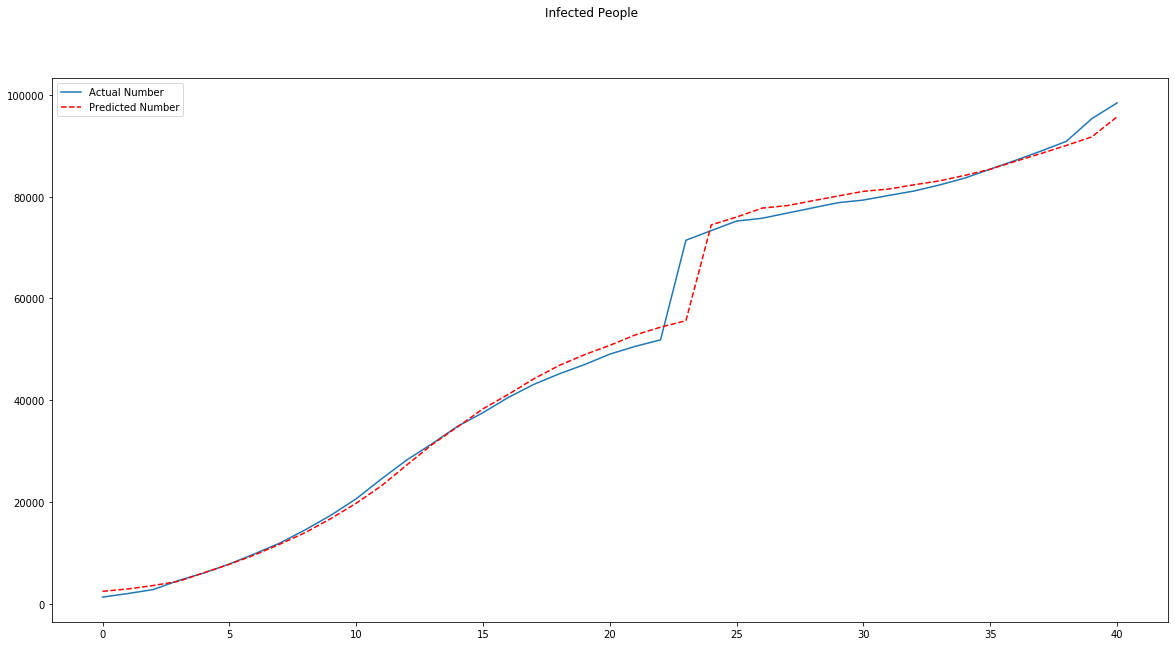

In [51]:
lstm.eval()
train_predict_inf = lstm(dataX_inf)

data_predict_inf = train_predict_inf.data.numpy()
dataY_plot_inf = dataY_inf.data.numpy()

data_predict_inf = sc.inverse_transform(data_predict_inf)
dataY_plot_inf = sc.inverse_transform(dataY_plot_inf)

plt.figure(figsize=(20,10))
plt.plot(dataY_plot_inf)
plt.plot(data_predict_inf, 'r--')
plt.suptitle('Infected People')
plt.legend(['Actual Number', 'Predicted Number'], loc='upper left')
plt.show()

### Forecasting Death Numbers

In [52]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data_dea = sc.fit_transform(tr_dea.values.reshape(-1, 1))

seq_length = 4
x_dea, y_dea = sliding_windows(training_data_dea, seq_length)

dataX_dea = Variable(torch.Tensor(np.array(x_dea)))
dataY_dea = Variable(torch.Tensor(np.array(y_dea)))

trainX_dea = Variable(torch.Tensor(np.array(x_dea)))
trainY_dea = Variable(torch.Tensor(np.array(y_dea)))

In [53]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Training the model

In [54]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX_dea)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_dea)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.26220
Epoch: 100, loss: 0.00122
Epoch: 200, loss: 0.00086
Epoch: 300, loss: 0.00071
Epoch: 400, loss: 0.00061
Epoch: 500, loss: 0.00051
Epoch: 600, loss: 0.00042
Epoch: 700, loss: 0.00031
Epoch: 800, loss: 0.00027
Epoch: 900, loss: 0.00026
Epoch: 1000, loss: 0.00024
Epoch: 1100, loss: 0.00023
Epoch: 1200, loss: 0.00022
Epoch: 1300, loss: 0.00020
Epoch: 1400, loss: 0.00019
Epoch: 1500, loss: 0.00018
Epoch: 1600, loss: 0.00018
Epoch: 1700, loss: 0.00017
Epoch: 1800, loss: 0.00017
Epoch: 1900, loss: 0.00017


### Predicting the results

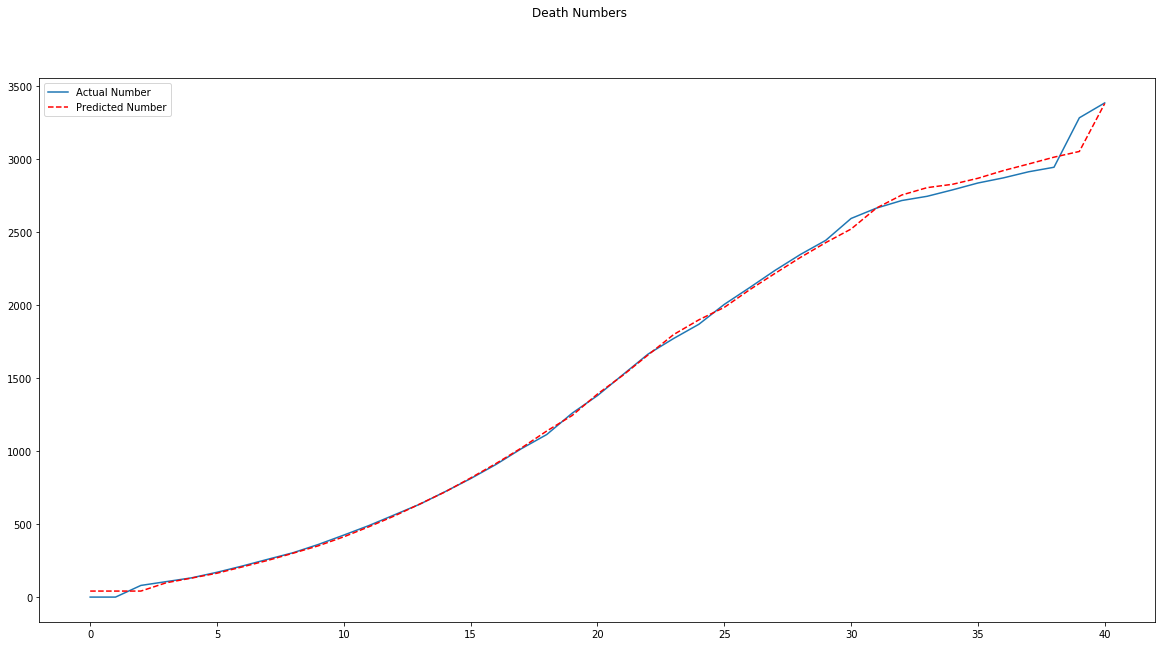

In [55]:
lstm.eval()
train_predict_dea = lstm(dataX_dea)

data_predict_dea = train_predict_dea.data.numpy()
dataY_plot_dea = dataY_dea.data.numpy()

data_predict_dea = sc.inverse_transform(data_predict_dea)
dataY_plot_dea = sc.inverse_transform(dataY_plot_dea)

plt.figure(figsize=(20,10))
plt.plot(dataY_plot_dea)
plt.plot(data_predict_dea, 'r--')
plt.suptitle('Death Numbers')
plt.legend(['Actual Number', 'Predicted Number'], loc='upper left')
plt.show()

## Plotting Everything

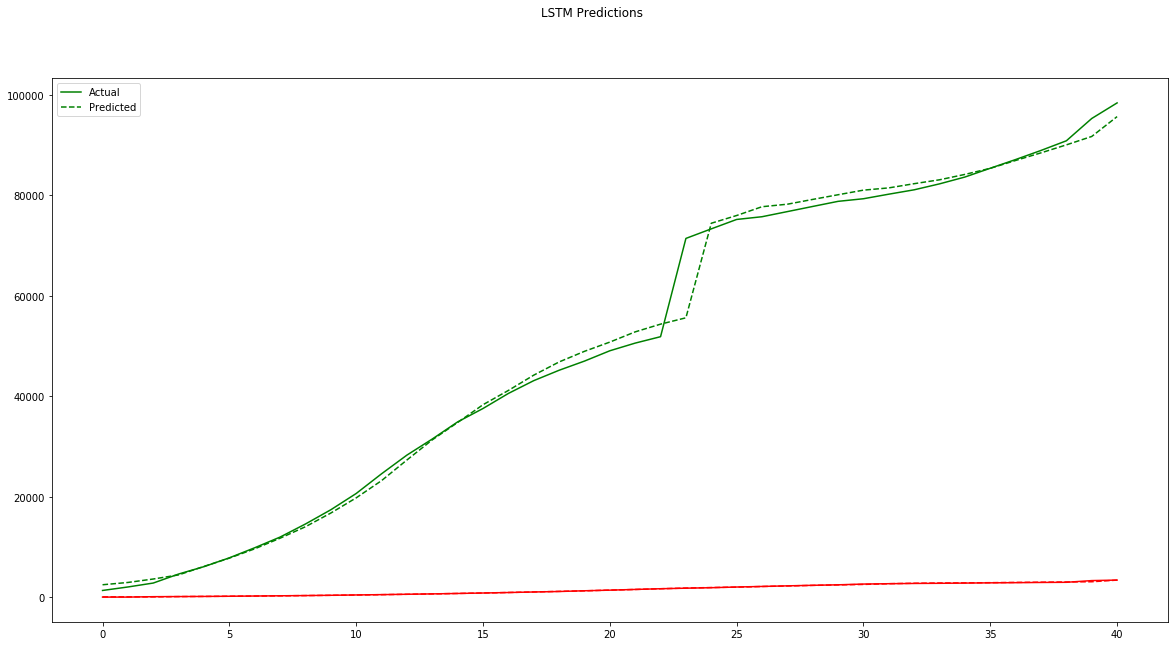

In [56]:
plt.figure(figsize=(20,10))
plt.plot()
plt.plot(dataY_plot_inf,'g')
plt.plot(data_predict_inf, 'g--')
plt.suptitle('Infected People')
plt.plot(dataY_plot_dea,'r')
plt.plot(data_predict_dea, 'r--')
plt.suptitle('LSTM Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [57]:
df

,Infected,Deaths
Date,,
2020-01-21,282.0,0.0
2020-01-22,314.0,0.0
2020-01-23,581.0,0.0
2020-01-24,846.0,0.0
2020-01-25,1320.0,0.0
2020-01-26,2014.0,0.0
2020-01-27,2798.0,80.0
2020-01-28,4593.0,106.0
2020-01-29,6065.0,132.0
